In [26]:
import sys
sys.path.append(".")

In [27]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
import matplotlib.pylab as plt
from pathlib import Path
from tensorflow.keras import layers
import datetime

In [28]:
model_name_it = "Outputs/Efficient_net_B0_it_52123.h5"

In [29]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [30]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

In [31]:
monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=1,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

In [32]:
def scheduler(epoch, lr):
    if epoch%30 == 0 and epoch!= 0:
        lr = lr/2
    return lr

In [33]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [34]:
#%load_ext tensorboard

In [35]:
#log_dir = "Outputs/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [36]:
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "rotation_range":180,\
              "width_shift_range":0.3,\
              "height_shift_range":0.3, \
              "shear_range":0.3, \
              "zoom_range":0.3,\
              "vertical_flip":True, \
              "brightness_range": (0.2, 2)}

In [38]:
generator = ImageDataGenerator(**gen_params, validation_split=0.2,  preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

In [39]:
bs = 16 # batch size

In [40]:
path = Path("../dataset/")

In [41]:
img_height = 224 #B0
img_width = 224 #B0


In [42]:
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades",\
               "3_clubs","3_diamonds","3_hearts","3_spades",\
               "4_clubs","4_diamonds","4_hearts","4_spades",\
               "5_clubs","5_diamonds","5_hearts","5_spades",\
               "6_clubs","6_diamonds","6_hearts","6_spades",\
               "7_clubs","7_diamonds","7_hearts","7_spades",\
               "8_clubs","8_diamonds","8_hearts","8_spades",\
               "9_clubs","9_diamonds","9_hearts","9_spades",\
               "10_clubs","10_diamonds","10_hearts","10_spades",\
               "ace_clubs","ace_diamonds","ace_hearts","ace_spades",\
               "jack_clubs","jack_diamonds","jack_hearts","jack_spades",\
               "king_clubs","king_diamonds","king_hearts","king_spades",\
               "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]

In [43]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    shuffle = True,
    interpolation="nearest",
    seed=42,
    classes=classes_names) # set as training data

Found 24952 images belonging to 52 classes.


In [44]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    seed=42,
    classes=classes_names) # set as validation data

Found 6206 images belonging to 52 classes.


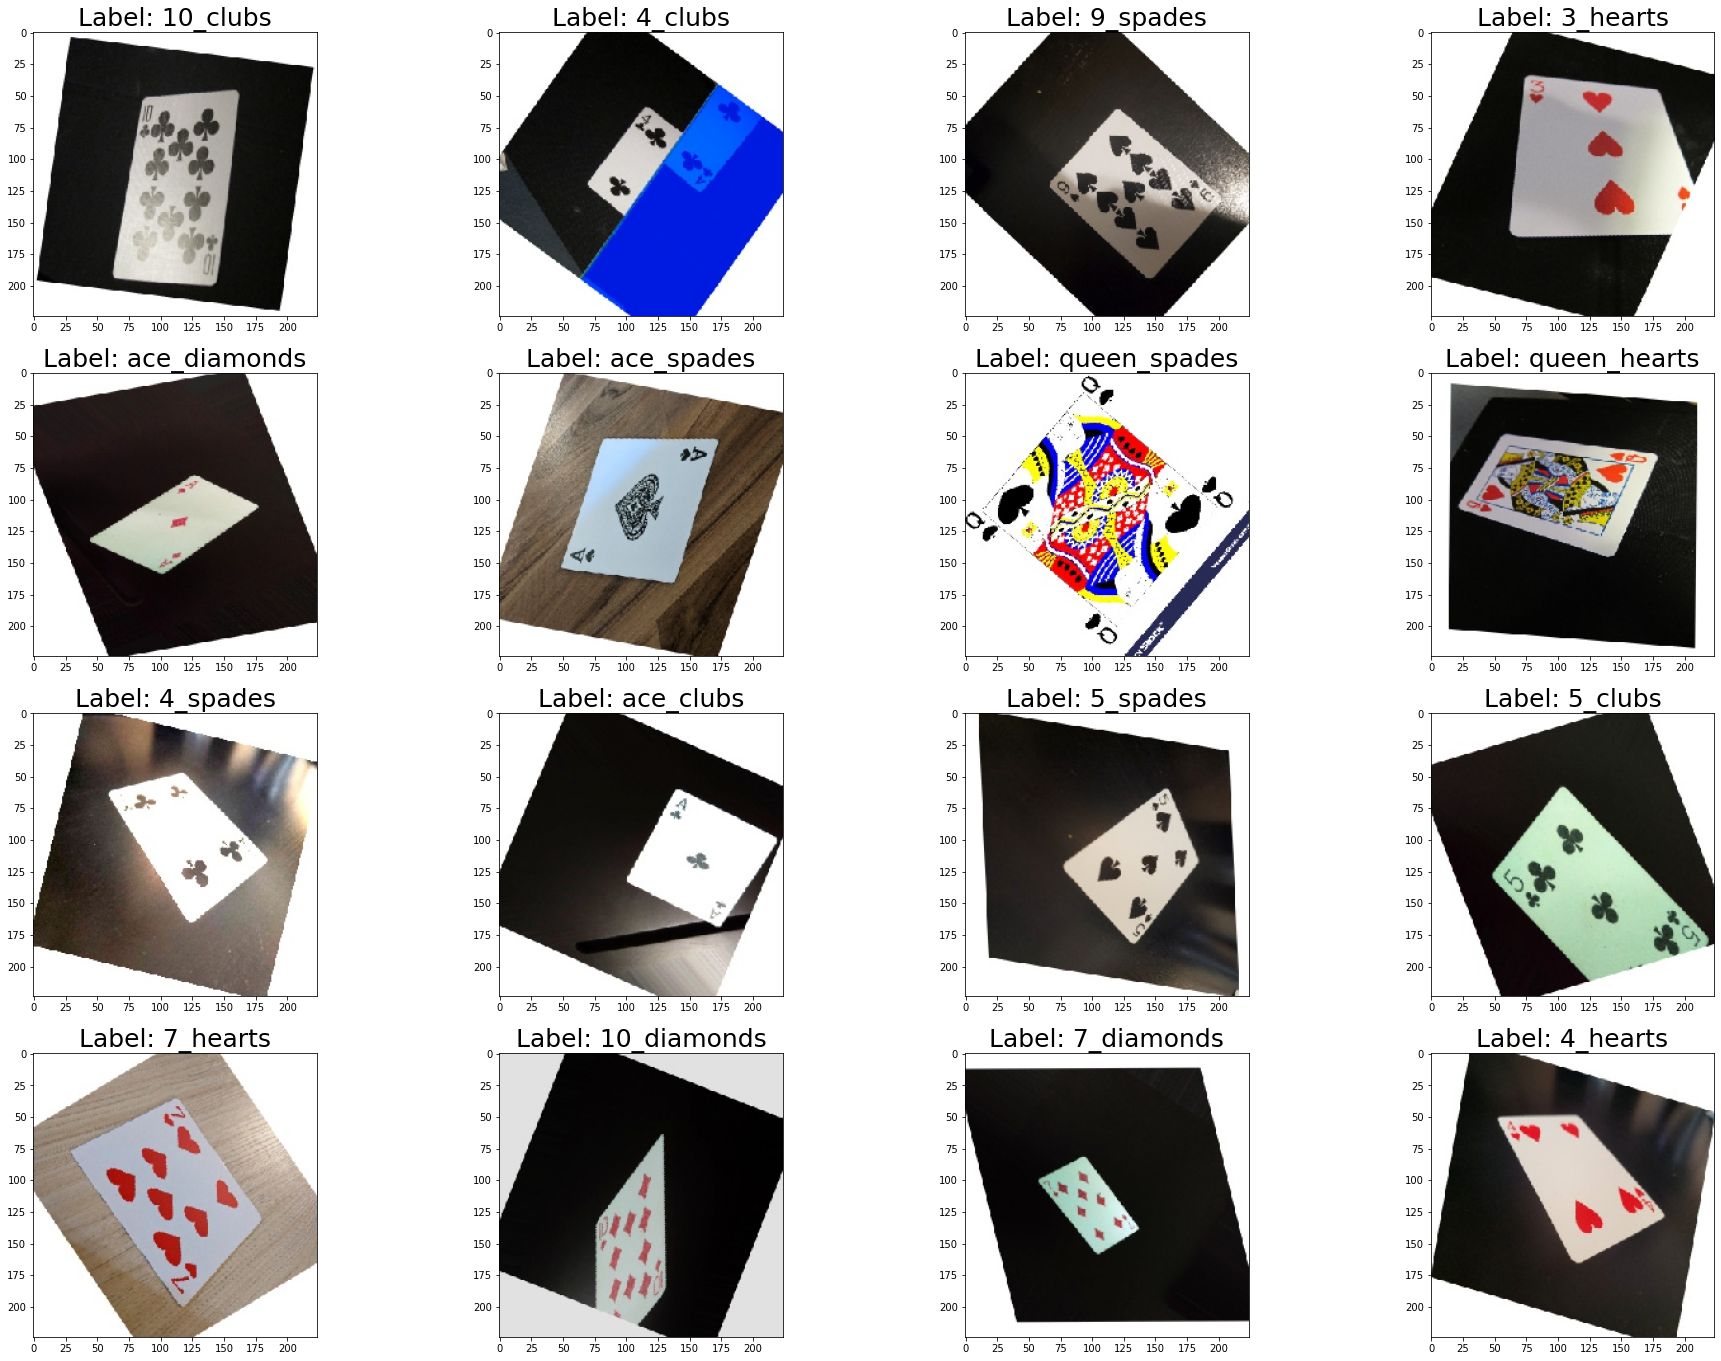

In [21]:
#Exploratory data analysis
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_generator.__getitem__(0)

for ii in range(int(bs)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(Ybatch[ii].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()

In [69]:
# Defining the model

trainable_flag = True
include_top_flag = False
weigths_value = 'imagenet'

if trainable_flag:
    include_top_flag = True
    weigths_value = None
else:
    include_top_flag = False
    weigths_value = 'imagenet'    


In [70]:
print(weigths_value)
print(include_top_flag)
print(trainable_flag)


None
True
True


In [71]:
inputs = layers.Input(shape=(img_height,img_width,3))
outputs = tf.keras.applications.EfficientNetB0(include_top=include_top_flag, weights=weigths_value,drop_connect_rate=0.3, classes=len(classes_names))(inputs)
model = tf.keras.Model(inputs,  outputs)

In [72]:
print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 52)               4116183   
                                                                 
Total params: 4,116,183
Trainable params: 4,074,160
Non-trainable params: 42,023
_________________________________________________________________
None


In [73]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), #
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [74]:
#model = tf.keras.models.load_model('BEST_MODEL_B0/EfficientNetB0_52_96_percent_last_model.h5')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 52)               4116183   
                                                                 
Total params: 4,116,183
Trainable params: 4,074,160
Non-trainable params: 42,023
_________________________________________________________________


In [75]:
history_it = model.fit(train_generator, epochs=1000, verbose = 1, \
                       workers=8, validation_data = (validation_generator), callbacks= [monitor_it,early_stop,lr_schedule])

Epoch 1/1000
1560/1560 [==============================] - ETA: 0s - loss: 3.3107 - accuracy: 0.0955
Epoch 1: val_loss improved from inf to 3.17742, saving model to Outputs\Efficient_net_B0_it_52123.h5
1560/1560 [==============================] - 402s 253ms/step - loss: 3.3107 - accuracy: 0.0955 - val_loss: 3.1774 - val_accuracy: 0.0964 - lr: 0.0010
Epoch 2/1000
1560/1560 [==============================] - ETA: 0s - loss: 2.1549 - accuracy: 0.2936
Epoch 2: val_loss improved from 3.17742 to 2.30469, saving model to Outputs\Efficient_net_B0_it_52123.h5
1560/1560 [==============================] - 392s 252ms/step - loss: 2.1549 - accuracy: 0.2936 - val_loss: 2.3047 - val_accuracy: 0.2204 - lr: 0.0010
Epoch 3/1000
1560/1560 [==============================] - ETA: 0s - loss: 1.5134 - accuracy: 0.4876
Epoch 3: val_loss improved from 2.30469 to 2.14295, saving model to Outputs\Efficient_net_B0_it_52123.h5
1560/1560 [==============================] - 391s 250ms/step - loss: 1.5134 - accuracy: 0

In [78]:
model.save('Outputs/Efficient_net_B0_it_52_no_aug_last_model.h5')
np.save('Outputs/Efficient_net_B0_it_52_no_aug.npy',history_it.history)


In [ ]:
# list all data in history
print(chistory_it.keys())
# summarize history for accuracy
plt.plot(history_it['accuracy'])
plt.plot(history_it['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_it['loss'])
plt.plot(history_it['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()